In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [65]:
train = pd.read_csv("data_HP/train.csv")
test = pd.read_csv("data_HP/test.csv")
test_ID = test['Id']
train_ID = train['Id']


In [66]:
print("Train shape:", train.shape)
train.head()

Train shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Visualizing Target Variable(Price)

Text(0.5, 1.0, 'Distribution of salesprice')

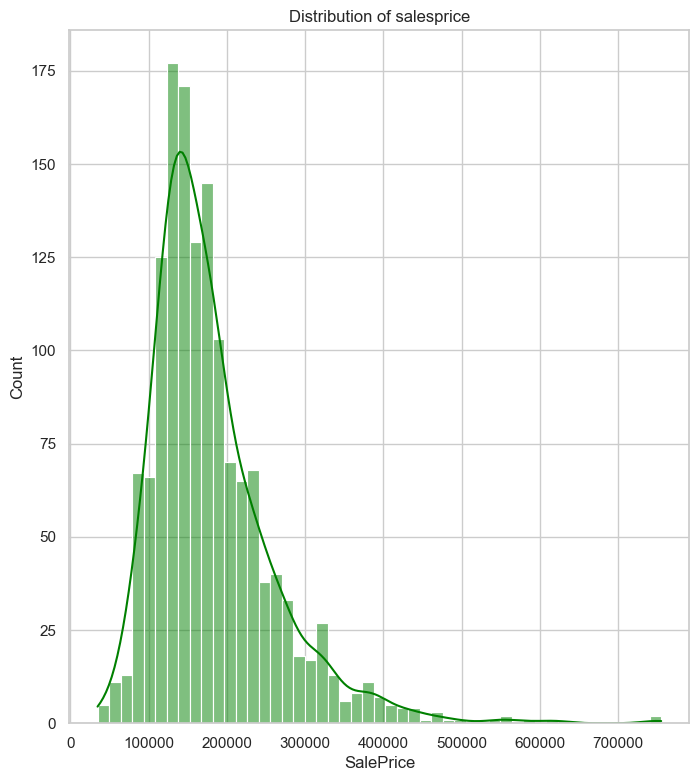

In [67]:
plt.figure(figsize=(8,9))
sns.histplot(train['SalePrice'],kde=True,color='green')
plt.title('Distribution of salesprice')

## Correlation Matrix

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd'],
      dtype='object')


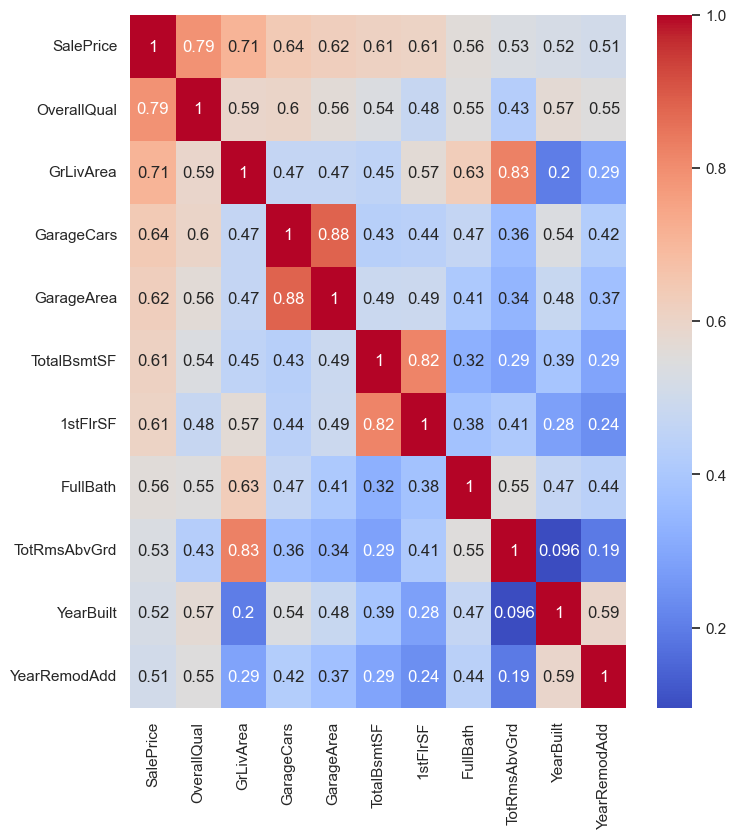

In [68]:
list(set(train.dtypes.tolist()))

numeric_train = train.select_dtypes(include=['int64','float64'])
categorical_train = train.select_dtypes(include=['O'])

corrmat = numeric_train.corr()
top_corr_features = corrmat['SalePrice'].sort_values(ascending=False)[:11]


plt.figure(figsize=(8,9))
sns.heatmap(numeric_train[top_corr_features.index].corr(),annot=True,cmap="coolwarm")
print(top_corr_features.index)

## Missing Data

In [69]:
all_data = pd.concat([train.drop(columns=["SalePrice"]),test])
missing = all_data.isnull().sum()
missing = missing[missing>0].sort_values(ascending=False)
print(missing)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageCond       159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageArea         1
GarageCars         1
Electrical         1
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64


## Imputing data

In [70]:
#for the categorical
for col in all_data.select_dtypes(include='object').columns:
    all_data[col].fillna('None',inplace=True)

# for numerical
for col in all_data.select_dtypes(exclude='object').columns:
    all_data[col].fillna(all_data[col].median(),inplace=True)

## Feature engineeiring

In [71]:
all_data["TotalSF"] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

## Label Encoding

In [77]:
cols = all_data.select_dtypes(include="object").columns
for col in cols:
    lbl = LabelEncoder()
    all_data[col] = lbl.fit_transform(all_data[col])


In [79]:
scaler = StandardScaler()
all_data_scaled = scaler.fit_transform(all_data)


In [80]:
X = all_data_scaled[:train.shape[0]]
X_test = all_data_scaled[train.shape[0]:]
y = np.log1p(train['SalePrice'])

In [81]:
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Cross-Validation RMSE
score = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
print("CV RMSE Score: {:.4f}".format(score.mean()))

# Fit the model
model.fit(X, y)

CV RMSE Score: 0.1246


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)